# Congressional Tweets Classification
## Derek Caramella
## 08 April 2022

# Table of Contents
1. [Modules](#modules)
    1. [Import Modules](#import-modules)
2. [Descriptive Analysis](#descriptive-analysis)
    1. [Text Cleaner](#text-cleaner)
    2. [Descriptive Statistics](#descriptive-statistics)
    3. [Time Series](#time-series)
    4. [Latent Dirichlet Allocation](#LDA)
    5. [Non-Negative Matrix Factorization](#non-negative-matrix-factorization)
3. [Model Creation & Predicition](#model-creation-prediction)
    1. [Preprocessing](#preprocessing)
    2. [Model Creation](#model-creation)
    3. [Prediction](#prediction)
    4. [Evaulation](#evaulation)

# Modules
<a class='anchor' id='modules'></a>

## Import Modules
<a class='anchor' id='import-modules'></a>

In [1]:
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import regularizers

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import pyLDAvis.sklearn

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import openpyxl
import warnings
import random
import os

import pickle

import matplotlib.font_manager
warnings.filterwarnings('ignore')  # Filter Errors
plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman
plt.rcParams['axes.grid'] = True  # Ensure line graphs display on graphs

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

In [2]:
# Import the raw dataset
training_tweet_df = pd.read_csv(r'congressional_tweet_training_data.csv')
test_tweet_df = pd.read_csv(r'congressional_tweet_test_data.csv')

training_tweet_df['Train'] = 1
test_tweet_df['Train'] = 0

raw_tweet_df = training_tweet_df.append(test_tweet_df)

raw_tweet_df.head(3)

,favorite_count,full_text,hashtags,retweet_count,year,party_id,Train,Id,party
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017.0,R,1,NaN,NaN
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020.0,R,1,NaN,NaN
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014.0,R,1,NaN,NaN


In [3]:
# Replace time feature with datetime object
raw_tweet_df['year'] = raw_tweet_df['year'].fillna(value=raw_tweet_df['year'].mean())
raw_tweet_df['year'] = raw_tweet_df['year'].astype('int32').astype('str')
raw_tweet_df['year'] = pd.to_datetime(raw_tweet_df['year'], format='%Y')

raw_tweet_df.head(3)

,favorite_count,full_text,hashtags,retweet_count,year,party_id,Train,Id,party
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",KUSI,10,2017-01-01,R,1,NaN,NaN
1,258,"b""Today I'm urging the @CDCgov to immediately ...",Coronavirus,111,2020-01-01,R,1,NaN,NaN
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",MO03,2,2014-01-01,R,1,NaN,NaN


In [4]:
raw_tweet_df['hashtags'] = raw_tweet_df['hashtags'].apply(lambda x: x.split())

raw_tweet_df.head(3)

,favorite_count,full_text,hashtags,retweet_count,year,party_id,Train,Id,party
0,0,"b""RT @KUSINews: One of our longtime viewers wa...",[KUSI],10,2017-01-01,R,1,NaN,NaN
1,258,"b""Today I'm urging the @CDCgov to immediately ...",[Coronavirus],111,2020-01-01,R,1,NaN,NaN
2,0,"b'Tomorrow, #MO03 seniors graduate from Calvar...",[MO03],2,2014-01-01,R,1,NaN,NaN


In [5]:
raw_tweet_df.party_id.fillna(raw_tweet_df.party, inplace=True)

In [6]:
raw_tweet_df['party_id'].unique()

array(['R', 'D'], dtype=object)

## Text Cleaner
<a class='anchor' id='text-cleaner'></a>

In [6]:
def text_cleaner(text):
    """
    Removes stopwords, words shorter than 3 characters, all links (href), emojis, & punctuation.
    :type text: string
    """
    additional_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 
                                'we', 'our', 'ours', 'ourselves', 'you', 
                                "you're", "you've", "you'll", "you'd", 'your', 
                                'yours', 'yourself', 'yourselves', 'he', 'him', 
                                'his', 'himself', 'she', "she's", 'her', 'hers',
                                'herself', 'it', "it's", 'its', 'itself', 'they',
                                'them', 'their', 'theirs', 'themselves', 'what',
                                'which', 'who', 'whom', 'this', 'that', "that'll",
                                'these', 'those', 'am', 'is', 'are', 'was', 'were',
                                'be', 'been', 'being', 'have', 'has', 'had', 'having',
                                'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
                                'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
                                'at', 'by', 'for', 'with', 'about', 'against', 'between',
                                'into', 'through', 'during', 'before', 'after', 'above', 
                                'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
                                'over', 'under', 'again', 'further', 'then', 'once', 'here',
                                'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
                                'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only',
                                'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can',
                                'will', 'just', 'don', "don't", 'should', "should've", 'now',
                                'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 
                                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
                                'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', 
                                "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't",
                                'won', "won't", 'wouldn', "wouldn't"])
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    text = text[2:-1]  # Remove the leading b, it looks like it's encoded but it's not
    text = text.replace('&amp;', 'and')
    text = text.replace(r"\'s", r"'s'")
    text = re.sub(r'[0-9]', ' ', text) # Match all digits in the string and replace them by empty string
    text = ' '.join(filter(lambda x:x[0]!=r'//', text.split()))
    text = ' '.join(re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)',' ', text).split())  # Remove hashtags #Derek, would be '' & https: links
    
    text = re.sub(emoji_pattern, '', text)  # Remove all emoji patterns
    text = re.sub("<a.+?>", ' ', text)  # Remove url, but keep the label
    
    html_tag_cleaner = re.compile('<.*?>')  # Remove any html div
    text = re.sub(html_tag_cleaner, '', text)  # Execute html removal
    
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)  # Remove all special characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)  # Remove all words less than or equal to 3 characters
    text = text.lower()  # Lower case text
#     text = remove_stopwords(text)  # Removes stop words
    # Remove contractions or other custom stopwords
    text = ' '.join(e.lower() for e in text.split() if e.lower() not in additional_stopwords)
    
    text = re.sub(r"won't", "will not", text)  # Replace these words
    text = re.sub(r"can\'t", "can not", text)  # Replace these words
    text = re.sub(r"n\'t", " not", text)  # Replace these words
    text = re.sub(r"\'re", " are", text)  # Replace these words
    text = re.sub(r"\'s", " is", text)  # Replace these words
    text = re.sub(r"\'d", " would", text)  # Replace these words
    text = re.sub(r"\'ll", " will", text)  # Replace these words
    text = re.sub(r"\'t", " not", text)  # Replace these words
    text = re.sub(r"\'ve", " have", text)  # Replace these words
    text = re.sub(r"\'m", " am", text)  # Replace these words
    
    text = re.sub(' +', ' ', text)  # Remove double whitespace
    text = text.strip()  # Remove leading & trailing whitespace
    return text

In [7]:
# Tags the words in the text
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(nltk.corpus.wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(nltk.corpus.wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(nltk.corpus.wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(nltk.corpus.wordnet.ADV)
    else:
        return(None)

In [8]:
lemmatizer = WordNetLemmatizer()


# Lemmatizes the words in texts and returns the cleaned and lemmatized text
def lemmatize_text(text):
    # Tokenize the text and find the POS tag for each token
    text = text_cleaner(text)
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    # Tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None: # If there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:  # Else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return(' '.join(lemmatized_text))

In [10]:
raw_tweet_df['full_text_clean'] = raw_tweet_df['full_text'].apply(lambda x: lemmatize_text(x))  # Lemmatize global df

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

In [11]:
extend_party_codes_dict = {
    'D': 'Democrat',
    'R': 'Republican'
}

In [12]:
raw_tweet_df['party_id'] = raw_tweet_df['party_id'].map(extend_party_codes_dict)

In [13]:
raw_tweet_df['full_text_clean_length'] = raw_tweet_df['full_text_clean'].str.len()  # Number of characters in summary

In [14]:
raw_tweet_df[['party_id', 'full_text_clean_length', 'retweet_count']].groupby('party_id').describe().unstack(1).apply(lambda x: '%.3f' % x)

                               party_id  
full_text_clean_length  count  Democrat       589202.000
                               Republican     268601.000
                        mean   Democrat          101.915
                               Republican         87.468
                        std    Democrat           45.962
                               Republican         42.454
                        min    Democrat            0.000
                               Republican          0.000
                        25%    Democrat           67.000
                               Republican         58.000
                        50%    Democrat           90.000
                               Republican         77.000
                        75%    Democrat          141.000
                               Republican        109.000
                        max    Democrat          282.000
                               Republican        248.000
retweet_count           count  Democrat       

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


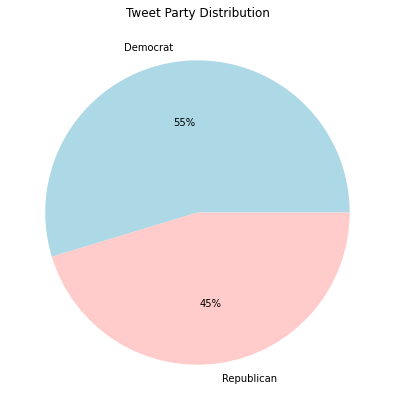

In [15]:
fig, ax = plt.subplots(constrained_layout=False, figsize=(15, 7))  # A figure with size attributes

tweet_count_by_party = raw_tweet_df.copy()  # Copy the raw text file

# Only take Year and text. We need text column to count by
tweet_count_by_party = tweet_count_by_party[['full_text_clean', 'party_id', 'Train']]
tweet_count_by_party = tweet_count_by_party[tweet_count_by_party['Train'] == 1]
tweet_count_by_party = tweet_count_by_party.groupby(by=['party_id'], as_index=False).count()

ax.pie(labels=tweet_count_by_party['party_id'], x=tweet_count_by_party['full_text_clean'], colors=['#ADD8E6', '#ffcccb'], autopct='%.0f%%')
ax.set_title('Tweet Party Distribution')  # Set title

plt.show()

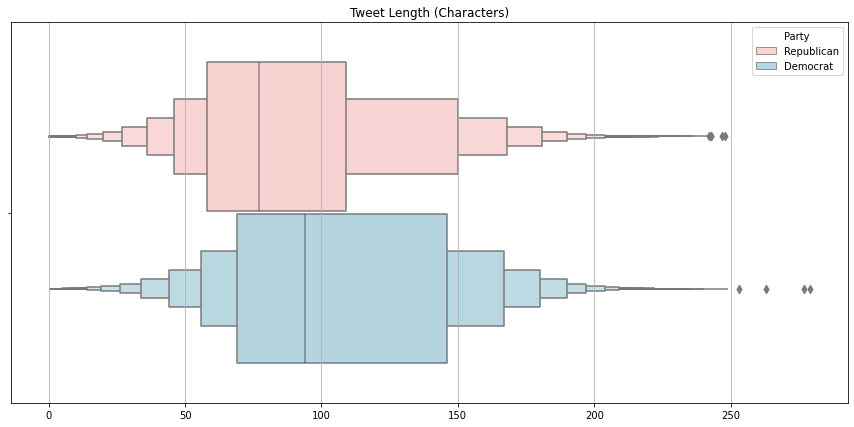

In [16]:
fig, ax = plt.subplots(constrained_layout=False, figsize=(15, 7))  # A figure with size attributes

"""
Boxenplots:
It is similar to a box plot in plotting a nonparametric representation of a
distribution in which all features correspond to actual observations. By plotting more quantiles, 
it provides more information about the shape of the distribution, particularly in the tails.
"""

# First plot, the number of characters in a summary distribution
sns.boxenplot(x=raw_tweet_df[raw_tweet_df['Train'] == 1]['full_text_clean_length'],
              hue=raw_tweet_df[raw_tweet_df['Train'] == 1]['party_id'],
              y=[""]*len(raw_tweet_df[raw_tweet_df['Train'] == 1]),
              palette=['#ffcccb', '#ADD8E6'],
              ax=ax).set(xlabel=None)
ax.legend().set_title('Party')
ax.set_title('Tweet Length (Characters)')  # Set title

plt.show()

## Time Series
<a class='anchor' id='time-series'></a>

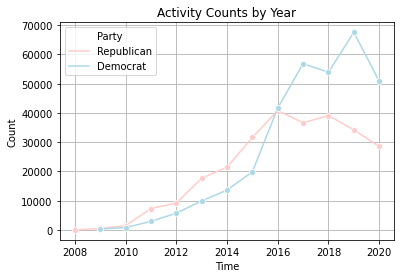

In [17]:
time_series_tweet_count = raw_tweet_df.copy()  # Copy the raw text file

# Only take Year and text. We need text column to count by
time_series_tweet_count = time_series_tweet_count[['year', 'full_text', 'party_id', 'Train']]
time_series_tweet_count = time_series_tweet_count[time_series_tweet_count['Train'] == 1]
# Group by Year to acquire count of texts
time_series_tweet_count = time_series_tweet_count.groupby(by=['year', 'party_id'], as_index=False).count()

fig, ax = plt.subplots(figsize=(6,4))  # A figure with size attributes
ax = sns.lineplot(data=time_series_tweet_count, 
                  x='year', 
                  y='full_text', 
                  hue='party_id',
                  marker='o',
                  palette=['#ffcccb', '#ADD8E6'])


ax.legend().set_title('Party')
ax.set_xlabel('Time')  # Set x title
ax.set_ylabel('Count')  # Set y title
ax.set_title('Activity Counts by Year')  # Set main title

plt.show()  # Show graph

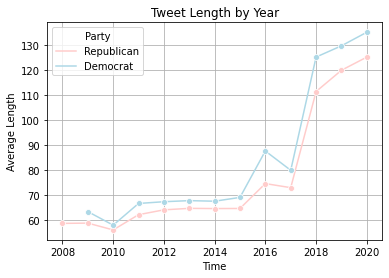

In [18]:
time_series_tweet_count = raw_tweet_df.copy()  # Copy the raw text file

# Only take Year and text. We need text column to count by
time_series_tweet_count = time_series_tweet_count[['year', 'full_text_clean_length', 'party_id', 'Train']]
time_series_tweet_count = time_series_tweet_count[time_series_tweet_count['Train'] == 1]
# Group by Year to acquire count of texts
time_series_tweet_count = time_series_tweet_count.groupby(by=['year', 'party_id'], as_index=False).mean()

fig, ax = plt.subplots(figsize=(6,4))  # A figure with size attributes
ax = sns.lineplot(data=time_series_tweet_count, 
                  x='year', 
                  y='full_text_clean_length',
                  hue='party_id',
                  marker='o', 
                  palette=['#ffcccb', '#ADD8E6'])

ax.legend().set_title('Party')
ax.set_xlabel('Time')  # Set x title
ax.set_ylabel('Average Length')  # Set y title
ax.set_title('Tweet Length by Year')  # Set main title

plt.show()  # Show graph

## Latent Dirichlet Allocation
<a class='anchor' id='LDA'></a>

In [19]:
text = ' '.join(review for review in raw_tweet_df['full_text_clean'])  # Acquire all cleaned text in one long string
cloud_mask = np.array(Image.open('img/president.jpg'))  # Load in custom image as the word cloud mask

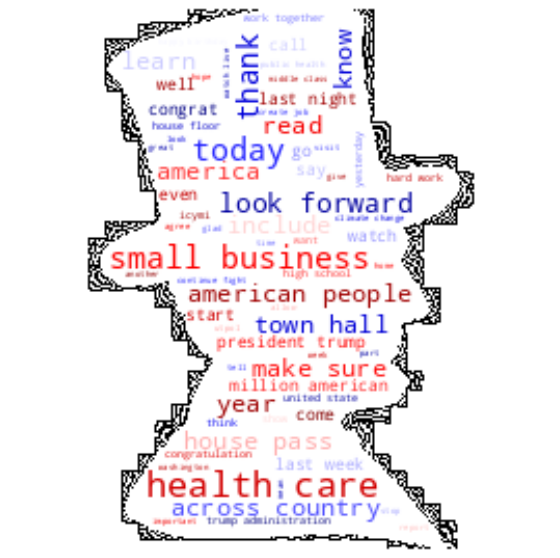

In [20]:
# Initialize Word Cloud with image mask
wc = WordCloud(background_color='white', max_words=500, mask=cloud_mask, contour_width=0.001, contour_color='black', colormap='seismic')
wc.generate(text)  # Populate the word cloud

plt.figure(figsize=(20, 10))  # Initialize plot
plt.imshow(wc, interpolation='bilinear')  # Show plot
plt.axis('off')  # Turn off axis for good apperance
plt.show()  # Show

In [21]:
def plot_top_words(model, feature_names, n_top_words, title):
    """
    A function for LDA & NMF to plot the top ten words in each topic.
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 15), sharex=True) # Initialize plot with subplots 1 row with 5 columns
    axes = axes.flatten()  # Flatten the axis
    for topic_idx, topic in enumerate(model.components_):  # For each topic id and topic in the model components
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]  # Sort the topics
        top_features = [feature_names[i] for i in top_features_ind]  # Sort the features
        weights = topic[top_features_ind]  # Acquire the weights

        ax = axes[topic_idx]  # Set the axes according to the topic id, so 1 is first and 5 is last
        ax.barh(top_features, weights, height=0.7)  # Set the bar height
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})  # Set the header depending on topic
        ax.invert_yaxis()  # Invert the y-axis so top word is first
        ax.tick_params(axis="both", which="major", labelsize=20)  # Set tick parameters
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  # Set title
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)  # Organize spacing for prettiness
    plt.show()

In [22]:
n_features = 1000  # 1,000 features
n_components = 5  # 5 components (topics)
n_top_words = 20  # 20 number top words

In [23]:
# Count vector for LDA
tf_vectorizer = CountVectorizer(max_df=0.95,  # maximum 95% apperance
                                min_df=2,  # Minimum greater than 2 appearances
                                max_features=n_features,  # 1,000 features
                                stop_words='english')  # English stop words

In [24]:
tf = tf_vectorizer.fit_transform(raw_tweet_df['full_text_clean'])  # Fit CountVector with clean text, then transform

In [25]:
# Take our CountVectorizer and train LDA object
lda = LatentDirichletAllocation(  # LDA object
    n_components=n_components,  # 5 topics
    max_iter=10,  # 10 maximum iterations
    learning_method='online',
    learning_offset=50.0,
    random_state=0)  # seed

In [26]:
lda.fit(tf)  # Fit our model

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=5, random_state=0)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


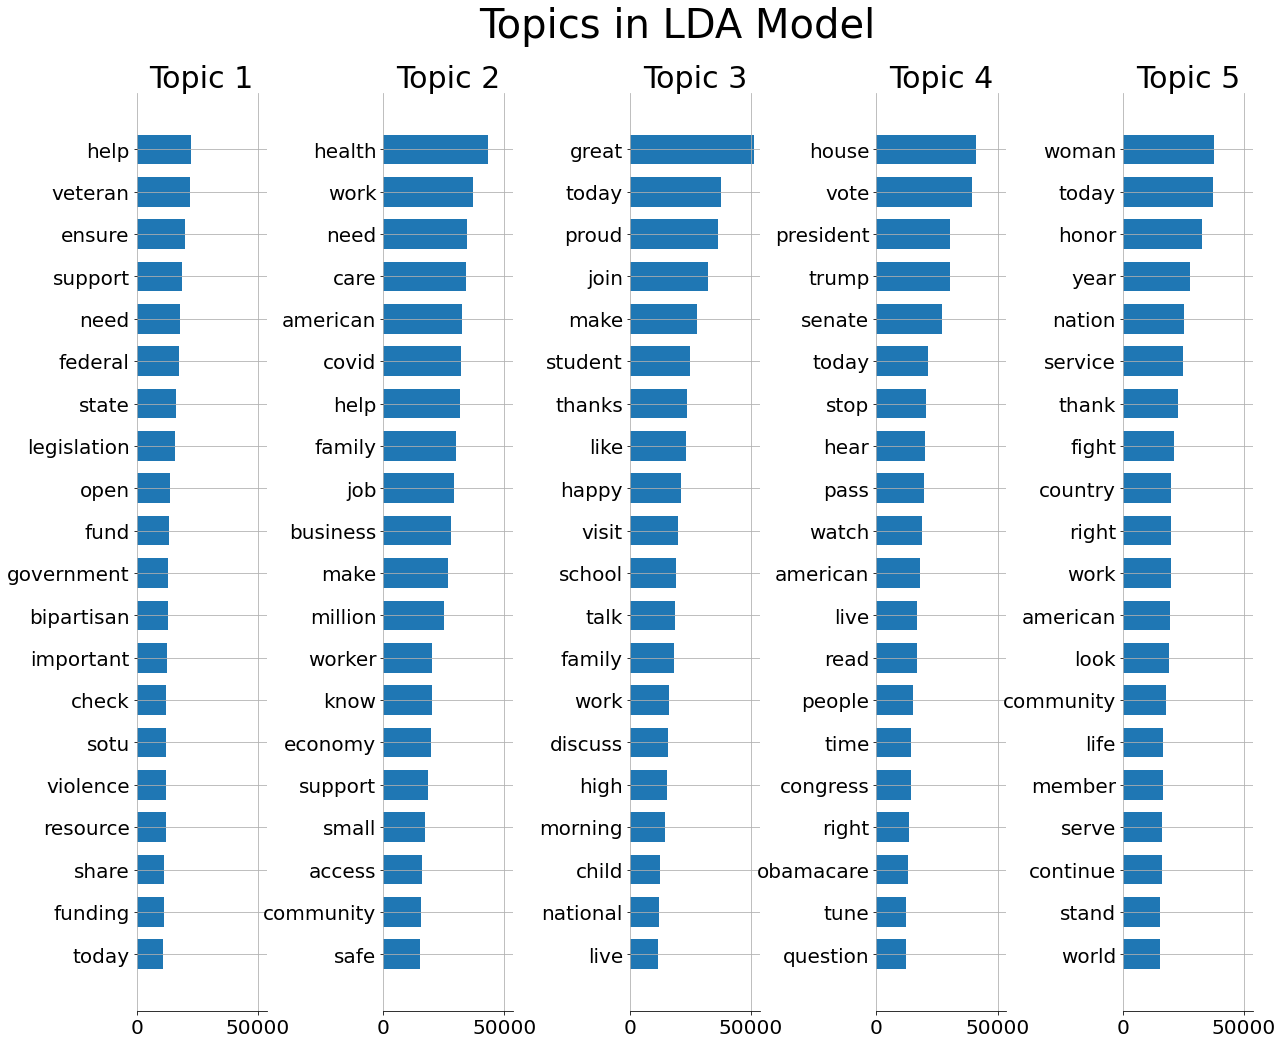

In [27]:
tf_feature_names = tf_vectorizer.get_feature_names()  # Acquire feature names
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA Model')  # plot

In [28]:
pyLDAvis.enable_notebook()  # Enable workbook for interaction
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')  # Cool interaction of topics
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  25.171433
4       51.163364 -159.968018       2        1  19.953137
2      -73.144554   21.523815       3        1  19.132969
3      -66.410133 -110.606438       4        1  18.298041
0       54.417324   12.443444       5        1  17.444419, topic_info=        Term          Freq          Total Category  logprob  loglift
378    great  50703.000000   50703.000000  Default  30.0000  30.0000
418    house  41270.000000   41270.000000  Default  29.0000  29.0000
956     vote  39634.000000   39634.000000  Default  28.0000  28.0000
985    woman  37627.000000   37627.000000  Default  27.0000  27.0000
697    proud  36181.000000   36181.000000  Default  26.0000  26.0000
..       ...           ...            ...      ...      ...      ...
400     help  22882.263717   58010.007649   Topic5  -3.9345   0.8159
839    state  16578.780972   32965.145773   Topic5  -4.2568   1.0588
866  support  19172.289360   48091.219033   Topic5  -4.1114   0.8265
578     need  18341.527546   57820.041064   Topic5  -4.1557   0.5980
898    today  10960.499365  107001.499551   Topic5  -4.6706  -0.5324

[239 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
6         1  0.999971          access
17        4  0.999932  administration
22        3  0.999868      affordable
38        1  0.460431        american
38        2  0.279252        american
...     ...       ...             ...
996       3  0.180666            year
996       4  0.073374            year
996       5  0.049353            year
997       3  0.999902       yesterday
998       2  0.999883           young

[264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

## Non-Negative Matrix Factorization
<a class='anchor' id='non-negative-matrix-factorization'></a>

In [29]:
#TfidfVectorizer for NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,  # maximum 95% apperance
                                   min_df=2,  # Minimum greater than 2 appearances
                                   max_features=n_features,  # 1,000 features
                                   stop_words='english')  # English stop words

In [30]:
tfidf = tfidf_vectorizer.fit_transform(raw_tweet_df['full_text_clean'])  # Fit TfidfVectorizer with clean text, then transform

In [31]:
# Take our TfidfVectorizer and train NMF object
nmf = NMF(n_components=n_components,  # 5 topics
          random_state=1,  # seed
          beta_loss='frobenius',  # Specify beta loss
          solver='mu',  # Mu solver
          max_iter=1000,  # Number of iterations
          alpha=0.1,  # Good learning rate
          l1_ratio=0.5)  # L1 ratio for correctness

In [32]:
nmf.fit(tfidf)  # Fit our NMF object

NMF(alpha=0.1, l1_ratio=0.5, max_iter=1000, n_components=5, random_state=1,
    solver='mu')

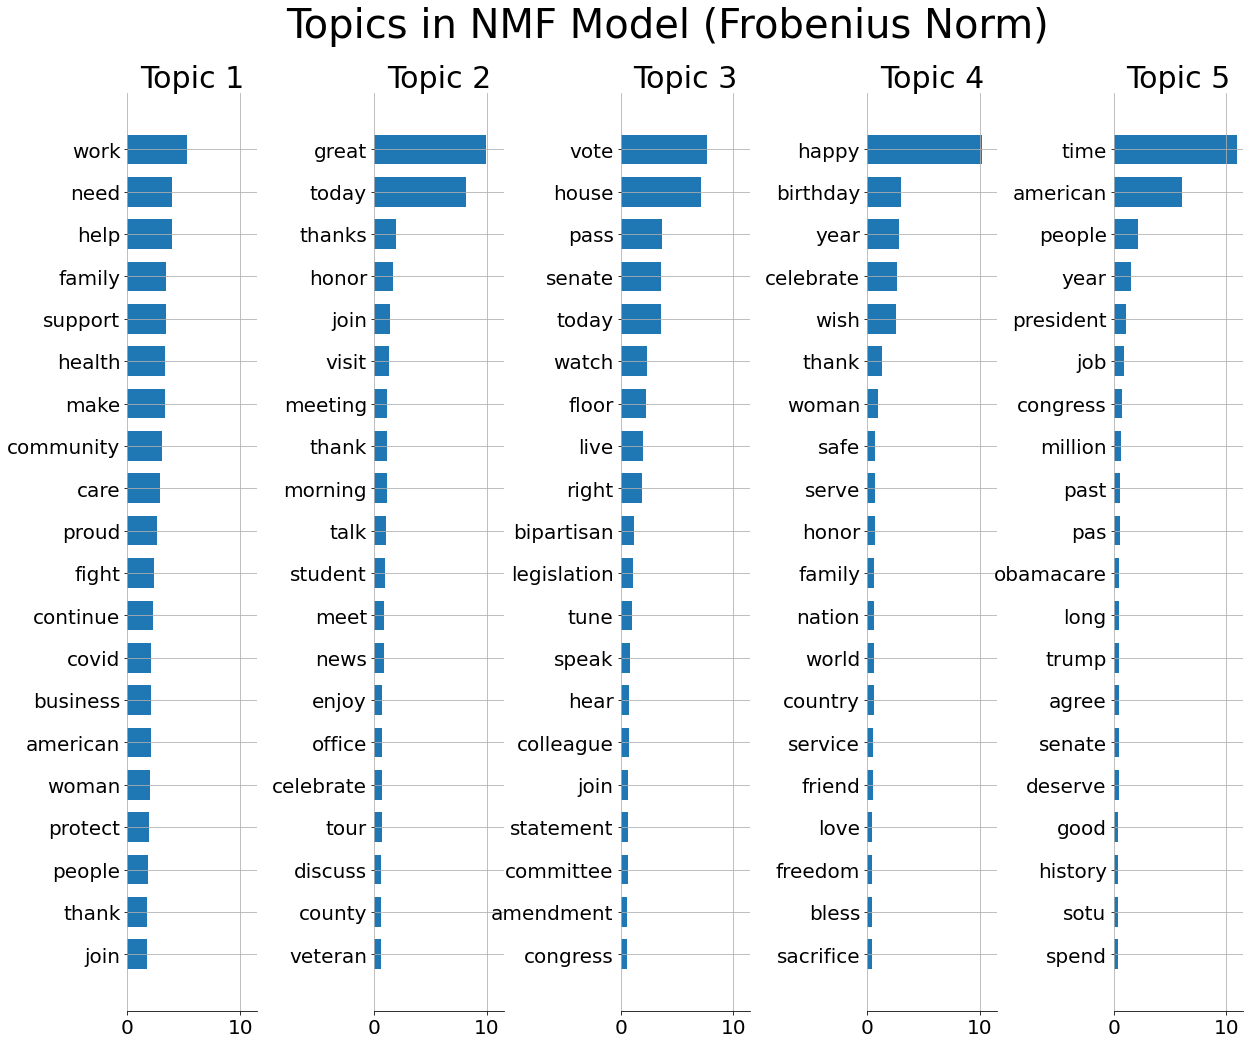

In [33]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()  # Acquire feature names
plot_top_words(nmf, tfidf_feature_names, n_top_words, 'Topics in NMF Model (Frobenius Norm)')  # Plot

# Model Creation & Predicition
<a class='anchor' id='model-creation-prediction'></a>

## Model Creation
<a class='anchor' id='model-creation'></a>

In [9]:
# Import the raw dataset
training_tweet_df = pd.read_csv(r'congressional_tweet_training_data.csv')
test_tweet_df = pd.read_csv(r'congressional_tweet_test_data.csv')

In [10]:
int_to_party_dict = {
    0: 'D',
    1: 'R'
}

party_to_int_dict = {
    'D': 0,
    'R': 1
}

In [11]:
X_train = training_tweet_df['full_text']
y_train = training_tweet_df['party_id'].map(party_to_int_dict)
y_train = y_train.values

X_test = test_tweet_df['full_text']
y_test = test_tweet_df['party'].map(party_to_int_dict)
y_test = y_test.values

In [12]:
X_train['full_text_clean'] = X_train.apply(lambda x: lemmatize_text(x))

In [13]:
sid_obj = SentimentIntensityAnalyzer()

X_train['Scores'] = X_train['full_text_clean'].apply(lambda x: sid_obj.polarity_scores(x))

sentiment = np.concatenate(
    (
        X_train['Scores'].str['neg'].values.reshape(-1, 1),
        X_train['Scores'].str['neu'].values.reshape(-1, 1),
        X_train['Scores'].str['pos'].values.reshape(-1, 1), 
        X_train['Scores'].str['compound'].values.reshape(-1, 1)
    )
    , axis=1)

In [14]:
# TfidfVectorizer for our x features. Fit on the train clean SummaryText. Keep object for the predict pipeline
tfidf_obj = CountVectorizer(ngram_range=(1,2), min_df=2, max_features=20500).fit(X_train['full_text_clean'])

# Transfprm clean Summary Text into the independant variables
X_train = tfidf_obj.transform(X_train['full_text_clean'])
X_train = X_train.toarray()  # Convert sparse array to array

In [15]:
X_train = np.concatenate((X_train, sentiment), axis=1)

In [26]:
def predict_tweet_party(test_x_dataframe, trained_tfidf_object, trained_model):
    """
    Pipeline for preprocessing and prediciton.
    """
#     Clean the Summary Text column
    test_x_dataframe['full_text_clean'] = test_x_dataframe.apply(lambda x: lemmatize_text(x))
    test_x_dataframe['Scores'] = test_x_dataframe['full_text_clean'].apply(lambda x: sid_obj.polarity_scores(x))
    sentiment = np.concatenate(
        (
            test_x_dataframe['Scores'].str['neg'].values.reshape(-1, 1),
            test_x_dataframe['Scores'].str['neu'].values.reshape(-1, 1),
            test_x_dataframe['Scores'].str['pos'].values.reshape(-1, 1), 
            test_x_dataframe['Scores'].str['compound'].values.reshape(-1, 1)
        )
        , axis=1)
#     Transform the clean Summary and Text column using the train trained_tfidf_object
    X = tfidf_obj.transform(test_x_dataframe['full_text_clean'])
    X = X.toarray()  # From sparse matrix to array
    X = np.concatenate((X, sentiment), axis=1)
    predictions = trained_model.predict(X)  # Predict

    return predictions

In [17]:
# Logostic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Random Forest
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
clf.fit(X_train, y_train)

In [ ]:
# Perceptron
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)

In [ ]:
# Tensor Flow
clf = models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

clf.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
clf.fit(X_train, y_train, epochs=15)

## Prediction
<a class='anchor' id='prediction'></a>

In [27]:
predictions = predict_tweet_party(X_test, tfidf_obj, clf)

In [28]:
submission = test_tweet_df.copy()
submission['party'] = predictions
submission['party'] = submission['party'].map(int_to_party_dict)

In [29]:
submission[['Id', 'party']].to_csv('output.csv', index=False)  # Export these features without the index